# Plan A (纯电梯) 灵敏度分析 - 蒙特卡洛模拟

## MCM/ICM 2025 - Question 2: 不确定性量化

**目标**: 
1. 计算时间和成本的概率分布
2. 确定90%和95%置信水平下的分位数值
3. 进行参数灵敏度分析（龙卷风图）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import exp, sqrt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# ==================== 基准参数 (Plan A: 纯电梯) - 基于研究数据校正 ====================
# 数据来源:
# - Space Elevator: Wikipedia - Space Elevator Economics (Edwards估计)
#   * 边际成本: ~$220/kg ($100/lb) to GEO = $2.2×10^5/ton
#   * 首台建造: ~$40B, 后续 ~$14.3B
#   * 运营成本: $1.56B for first 10 years
# - Rockets: Wikipedia - Falcon Heavy, SpaceX官网
#   * 可回收发射: $97M; 全抛弃: $150M
#   * LEO成本: $2,350/kg; GTO成本: $5,620/kg

BASE_PARAMS = {
    'M': 10**8,                 # 总运输量 (吨)
    'E_E_base': 179000 * 3,     # 电梯基础年运输能力 (吨/年)
    'C_E': 2.2 * 10**5,         # 电梯边际成本 (USD/吨) - Edwards ~$220/kg
    'F_E': 1.56 * 10**8,        # 电梯固定成本 (USD/年) - $1.56B/10yrs average
    'p_E': 0.003,                # 电梯年故障概率
    'sigma_swing': 1.5,         # 缆绳摆动参数 (度) - 考虑Coriolis力、太阳风、引力扰动
    'theta_limit': 4.0,         # 摆动角度限制 (度) - 工程设计容差
    'val_rep_E': 5 * 10**9,     # 电梯维修费用 (USD)
}

# 火箭参数 (用于对比)
ROCKET_PARAMS = {
    'C_R': 3.5 * 10**5,       # 火箭边际成本 (USD/吨) - $2,350/kg × 0.5 (2050)
    'F_R': 5 * 10**7,           # 火箭固定成本 (USD/年)
}

def calculate_plan_A(params):
    """计算Plan A的时间和成本"""
    M = params['M']
    E_E_base = params['E_E_base']
    C_E = params['C_E']
    F_E = params['F_E']
    p_E = params['p_E']
    sigma_swing = params['sigma_swing']
    theta_limit = params['theta_limit']
    val_rep_E = params['val_rep_E']
    
    # 有效运输能力 (考虑摆动)
    ff = 1 - exp(-theta_limit**2 / (2 * sigma_swing**2))
    E_E = E_E_base * ff
    
    # 时间期望 (考虑故障)
    E_T = M / (E_E * (1 - p_E))
    
    # 成本期望 (考虑维修)
    E_C = (M * C_E + M * F_E / E_E + M * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
    
    return E_T, E_C

# 基准结果
E_T_base, E_C_base = calculate_plan_A(BASE_PARAMS)
print("=" * 60)
print("基准参数下的 Plan A 结果 (基于研究数据校正)")
print("=" * 60)
print(f"电梯边际成本 C_E: ${BASE_PARAMS['C_E']:,.0f}/ton (~$220/kg)")
print(f"电梯固定成本 F_E: ${BASE_PARAMS['F_E']/10**8:.2f}亿USD/年")
print("-" * 60)
print(f"时间期望: {E_T_base:.2f} 年")
print(f"成本期望: {E_C_base:.2f} 亿USD")

基准参数下的 Plan A 结果 (基于研究数据校正)
电梯边际成本 C_E: $220,000/ton (~$220/kg)
电梯固定成本 F_E: $1.56亿USD/年
------------------------------------------------------------
时间期望: 192.27 年
成本期望: 220327.89 亿USD


In [3]:
# ==================== Monte Carlo Simulation ====================
def monte_carlo_simulation(n_simulations=1000000, random_seed=42):
    """
    Monte Carlo Simulation - Random sampling of uncertain parameters
    
    Uncertain parameters and distributions (基于研究数据校正):
    1. p_E (failure probability): Beta distribution, mean 0.03
    2. sigma_swing (swing parameter): Normal distribution, mean 1.5, std 0.3
    3. theta_limit (angle limit): Uniform distribution, range [3, 7]
    4. val_rep_E (repair cost): Lognormal distribution, mean 5 billion
    5. C_E (marginal cost): Triangular distribution, [1.5×10^5, 2.2×10^5, 3×10^5] (基于Edwards估计范围)
    """
    np.random.seed(random_seed)
    
    # Define parameter distributions
    # p_E: Beta distribution (suitable for probability, range 0-1)
    # Set alpha=3, beta=97 to get mean ≈ 0.03
    p_E_samples = np.random.beta(a=3, b=97, size=n_simulations)
    
    # sigma_swing: Truncated normal distribution (positive values)
    # 考虑Coriolis力、太阳风、引力扰动，均值1.5度，标准差0.3度
    sigma_swing_samples = np.clip(
        np.random.normal(1.5, 0.3, size=n_simulations),
        0.8, 2.5
    )
    
    # theta_limit: Uniform distribution [3, 7] - 工程设计容差范围
    theta_limit_samples = np.random.uniform(3, 7, size=n_simulations)
    
    # val_rep_E: Lognormal distribution (repair costs have right skewness)
    val_rep_E_samples = np.random.lognormal(
        mean=np.log(5e9), sigma=0.3, size=n_simulations
    )
    
    # C_E: Triangular distribution - 基于Edwards估计范围校正
    # 乐观: $150/kg = 1.5×10^5/ton
    # 基准: $220/kg = 2.2×10^5/ton (Edwards estimate)
    # 悲观: $300/kg = 3×10^5/ton
    C_E_samples = np.random.triangular(
        left=1.5e5, mode=2.2e5, right=3e5, size=n_simulations
    )
    
    # Fixed parameters
    M = BASE_PARAMS['M']
    E_E_base = BASE_PARAMS['E_E_base']
    F_E = BASE_PARAMS['F_E']
    
    # Vectorized computation
    ff = 1 - np.exp(-theta_limit_samples**2 / (2 * sigma_swing_samples**2))
    E_E = E_E_base * ff
    
    # Time results
    T_results = M / (E_E * (1 - p_E_samples))
    
    # Cost results (100 million USD)
    C_results = (M * C_E_samples + 
                 M * F_E / E_E + 
                 M * p_E_samples * val_rep_E_samples / (E_E * (1 - p_E_samples))) / 10**8
    
    return {
        'T': T_results,
        'C': C_results,
        'p_E': p_E_samples,
        'sigma_swing': sigma_swing_samples,
        'theta_limit': theta_limit_samples,
        'val_rep_E': val_rep_E_samples,
        'C_E': C_E_samples
    }

# Run Monte Carlo simulation
N_SIM = 1000000
print(f"Running {N_SIM:,} Monte Carlo simulations (with corrected parameters)...")
mc_results = monte_carlo_simulation(n_simulations=N_SIM)
print("Simulation completed!")
print(f"\nC_E distribution: [{mc_results['C_E'].min()/1e5:.1f}, {np.median(mc_results['C_E'])/1e5:.1f}, {mc_results['C_E'].max()/1e5:.1f}] × 10^5 USD/ton")

Running 1,000,000 Monte Carlo simulations (with corrected parameters)...
Simulation completed!

C_E distribution: [1.5, 2.2, 3.0] × 10^5 USD/ton


In [4]:
# ==================== 统计分析 ====================
def analyze_distribution(data, name, unit):
    """分析分布统计量"""
    analysis = {
        'mean': np.mean(data),
        'median': np.median(data),
        'std': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'p5': np.percentile(data, 5),
        'p10': np.percentile(data, 10),
        'p90': np.percentile(data, 90),
        'p95': np.percentile(data, 95),
        'ci_90': [np.percentile(data, 5), np.percentile(data, 95)],
        'ci_95': [np.percentile(data, 2.5), np.percentile(data, 97.5)],
    }
    
    print(f"\n{'='*60}")
    print(f"{name} 分布分析")
    print(f"{'='*60}")
    print(f"均值: {analysis['mean']:.2f} {unit}")
    print(f"中位数: {analysis['median']:.2f} {unit}")
    print(f"标准差: {analysis['std']:.4f} {unit}")
    print(f"范围: [{analysis['min']:.2f}, {analysis['max']:.2f}] {unit}")
    print(f"-"*60)
    print(f"90% 置信区间: [{analysis['ci_90'][0]:.2f}, {analysis['ci_90'][1]:.2f}] {unit}")
    print(f"95% 置信区间: [{analysis['ci_95'][0]:.2f}, {analysis['ci_95'][1]:.2f}] {unit}")
    
    return analysis

# 分析时间分布
T_analysis = analyze_distribution(mc_results['T'], '运输时间', '年')

# 分析成本分布
C_analysis = analyze_distribution(mc_results['C'], '运输成本', '亿USD')


运输时间 分布分析
均值: 198.48 年
中位数: 194.02 年
标准差: 13.7019 年
范围: [186.27, 379.31] 年
------------------------------------------------------------
90% 置信区间: [188.42, 225.94] 年
95% 置信区间: [187.89, 239.49] 年

运输成本 分布分析
均值: 223990.42 亿USD
中位数: 223209.76 亿USD
标准差: 30671.5790 亿USD
范围: [150559.24, 300531.32] 亿USD
------------------------------------------------------------
90% 置信区间: [173510.63, 276198.90] 亿USD
95% 置信区间: [166799.02, 283408.16] 亿USD


In [5]:
# ==================== Key Results: 90%, 95%, and 99% Percentiles ====================
print("\n" + "="*70)
print("🎯 Key Results: Confidence Percentiles")
print("="*70)

# Time percentiles
T_90 = np.percentile(mc_results['T'], 90)
T_95 = np.percentile(mc_results['T'], 95)
T_99 = np.percentile(mc_results['T'], 99)

# Cost percentiles
C_90 = np.percentile(mc_results['C'], 90)
C_95 = np.percentile(mc_results['C'], 95)
C_99 = np.percentile(mc_results['C'], 99)

print(f"""
【Time Analysis】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▸ 90% Confidence: Time ≤ {T_90:.2f} years
  ▸ 95% Confidence: Time ≤ {T_95:.2f} years
  ▸ 99% Confidence: Time ≤ {T_99:.2f} years

【Cost Analysis】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▸ 90% Confidence: Cost ≤ {C_90:.2f} (100M USD)
  ▸ 95% Confidence: Cost ≤ {C_95:.2f} (100M USD)
  ▸ 99% Confidence: Cost ≤ {C_99:.2f} (100M USD)

【Comparison with Baseline】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Baseline Time: {E_T_base:.2f} years
  Baseline Cost: {E_C_base:.2f} (100M USD)
  
  Increase relative to baseline:
    99% Time: +{(T_99/E_T_base - 1)*100:.1f}%
    99% Cost: +{(C_99/E_C_base - 1)*100:.1f}%
""")


🎯 Key Results: Confidence Percentiles

【Time Analysis】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▸ 90% Confidence: Time ≤ 213.01 years
  ▸ 95% Confidence: Time ≤ 225.94 years
  ▸ 99% Confidence: Time ≤ 257.30 years

【Cost Analysis】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▸ 90% Confidence: Cost ≤ 266022.67 (100M USD)
  ▸ 95% Confidence: Cost ≤ 276198.90 (100M USD)
  ▸ 99% Confidence: Cost ≤ 289730.80 (100M USD)

【Comparison with Baseline】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Baseline Time: 192.27 years
  Baseline Cost: 220327.89 (100M USD)
  
  Increase relative to baseline:
    99% Time: +33.8%
    99% Cost: +31.5%



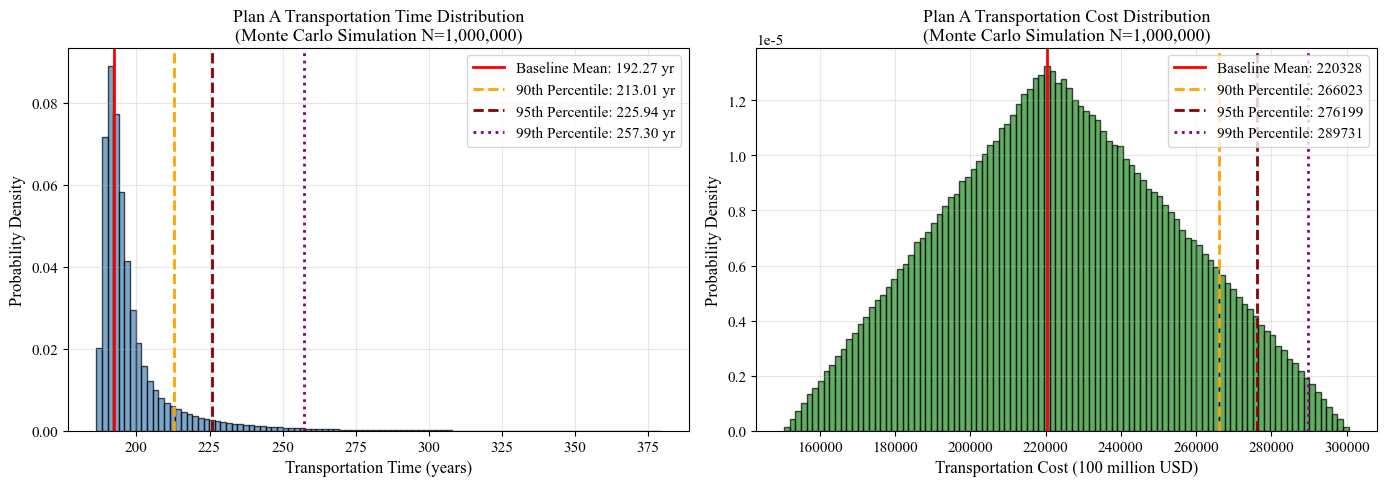

In [6]:
# ==================== Visualization 1: Distribution Histograms ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time distribution
ax1 = axes[0]
ax1.hist(mc_results['T'], bins=100, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(E_T_base, color='red', linestyle='-', linewidth=2, label=f'Baseline Mean: {E_T_base:.2f} yr')
ax1.axvline(T_90, color='orange', linestyle='--', linewidth=2, label=f'90th Percentile: {T_90:.2f} yr')
ax1.axvline(T_95, color='darkred', linestyle='--', linewidth=2, label=f'95th Percentile: {T_95:.2f} yr')
ax1.axvline(T_99, color='purple', linestyle=':', linewidth=2, label=f'99th Percentile: {T_99:.2f} yr')
ax1.set_xlabel('Transportation Time (years)', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.set_title('Plan A Transportation Time Distribution\n(Monte Carlo Simulation N=1,000,000)', fontsize=13)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Cost distribution
ax2 = axes[1]
ax2.hist(mc_results['C'], bins=100, density=True, alpha=0.7, color='forestgreen', edgecolor='black')
ax2.axvline(E_C_base, color='red', linestyle='-', linewidth=2, label=f'Baseline Mean: {E_C_base:.0f}')
ax2.axvline(C_90, color='orange', linestyle='--', linewidth=2, label=f'90th Percentile: {C_90:.0f}')
ax2.axvline(C_95, color='darkred', linestyle='--', linewidth=2, label=f'95th Percentile: {C_95:.0f}')
ax2.axvline(C_99, color='purple', linestyle=':', linewidth=2, label=f'99th Percentile: {C_99:.0f}')
ax2.set_xlabel('Transportation Cost (100 million USD)', fontsize=12)
ax2.set_ylabel('Probability Density', fontsize=12)
ax2.set_title('Plan A Transportation Cost Distribution\n(Monte Carlo Simulation N=1,000,000)', fontsize=13)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/sensitivity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

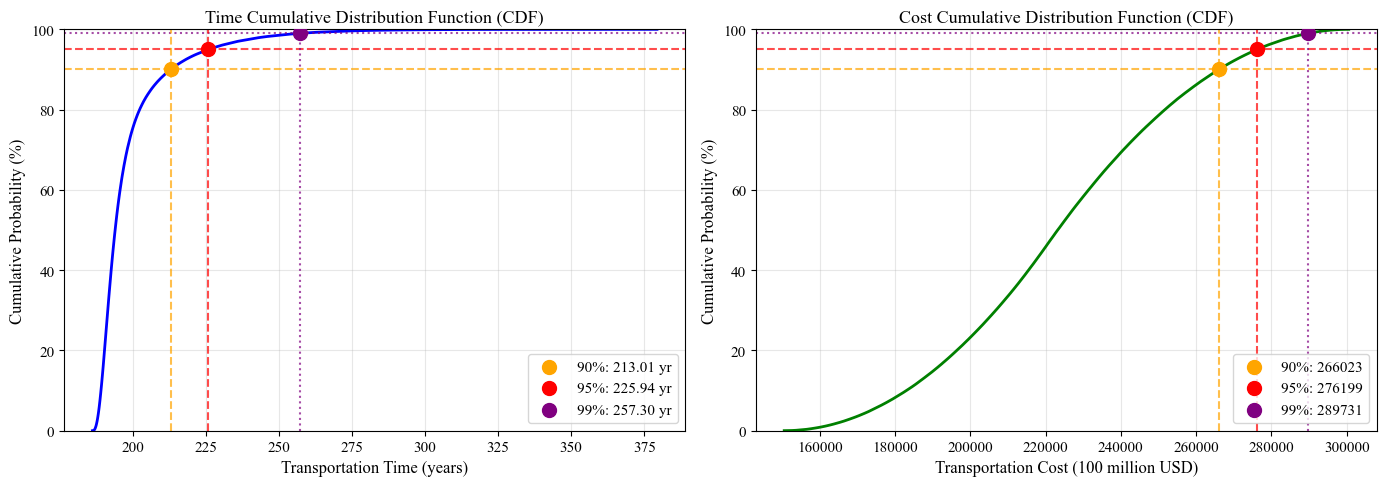

In [7]:
# ==================== Visualization 2: CDF Cumulative Distribution Function ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time CDF
ax1 = axes[0]
T_sorted = np.sort(mc_results['T'])
T_cdf = np.arange(1, len(T_sorted) + 1) / len(T_sorted)
ax1.plot(T_sorted, T_cdf * 100, 'b-', linewidth=2)
ax1.axhline(90, color='orange', linestyle='--', alpha=0.7)
ax1.axhline(95, color='red', linestyle='--', alpha=0.7)
ax1.axhline(99, color='purple', linestyle=':', alpha=0.7)
ax1.axvline(T_90, color='orange', linestyle='--', alpha=0.7)
ax1.axvline(T_95, color='red', linestyle='--', alpha=0.7)
ax1.axvline(T_99, color='purple', linestyle=':', alpha=0.7)
ax1.scatter([T_90], [90], color='orange', s=100, zorder=5, label=f'90%: {T_90:.2f} yr')
ax1.scatter([T_95], [95], color='red', s=100, zorder=5, label=f'95%: {T_95:.2f} yr')
ax1.scatter([T_99], [99], color='purple', s=100, zorder=5, label=f'99%: {T_99:.2f} yr')
ax1.set_xlabel('Transportation Time (years)', fontsize=12)
ax1.set_ylabel('Cumulative Probability (%)', fontsize=12)
ax1.set_title('Time Cumulative Distribution Function (CDF)', fontsize=13)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Cost CDF
ax2 = axes[1]
C_sorted = np.sort(mc_results['C'])
C_cdf = np.arange(1, len(C_sorted) + 1) / len(C_sorted)
ax2.plot(C_sorted, C_cdf * 100, 'g-', linewidth=2)
ax2.axhline(90, color='orange', linestyle='--', alpha=0.7)
ax2.axhline(95, color='red', linestyle='--', alpha=0.7)
ax2.axhline(99, color='purple', linestyle=':', alpha=0.7)
ax2.axvline(C_90, color='orange', linestyle='--', alpha=0.7)
ax2.axvline(C_95, color='red', linestyle='--', alpha=0.7)
ax2.axvline(C_99, color='purple', linestyle=':', alpha=0.7)
ax2.scatter([C_90], [90], color='orange', s=100, zorder=5, label=f'90%: {C_90:.0f}')
ax2.scatter([C_95], [95], color='red', s=100, zorder=5, label=f'95%: {C_95:.0f}')
ax2.scatter([C_99], [99], color='purple', s=100, zorder=5, label=f'99%: {C_99:.0f}')
ax2.set_xlabel('Transportation Cost (100 million USD)', fontsize=12)
ax2.set_ylabel('Cumulative Probability (%)', fontsize=12)
ax2.set_title('Cost Cumulative Distribution Function (CDF)', fontsize=13)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../results/sensitivity_cdf.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# ==================== 龙卷风图: 参数灵敏度分析 ====================
def tornado_analysis(base_params, perturbation=0.2):
    """
    龙卷风图分析 - 单因素灵敏度
    perturbation: ±20%扰动
    """
    E_T_base, E_C_base = calculate_plan_A(base_params)
    
    # 要分析的参数
    params_to_analyze = ['p_E', 'sigma_swing', 'theta_limit', 'val_rep_E', 'C_E', 'F_E']
    
    sensitivities_T = []
    sensitivities_C = []
    
    for param_name in params_to_analyze:
        # Low value
        params_low = base_params.copy()
        params_low[param_name] = base_params[param_name] * (1 - perturbation)
        T_low, C_low = calculate_plan_A(params_low)
        
        # High value
        params_high = base_params.copy()
        params_high[param_name] = base_params[param_name] * (1 + perturbation)
        T_high, C_high = calculate_plan_A(params_high)
        
        sensitivities_T.append({
            'param': param_name,
            'low': T_low,
            'high': T_high,
            'range': abs(T_high - T_low)
        })
        
        sensitivities_C.append({
            'param': param_name,
            'low': C_low,
            'high': C_high,
            'range': abs(C_high - C_low)
        })
    
    # 按影响大小排序
    sensitivities_T.sort(key=lambda x: x['range'], reverse=True)
    sensitivities_C.sort(key=lambda x: x['range'], reverse=True)
    
    return sensitivities_T, sensitivities_C, E_T_base, E_C_base

sens_T, sens_C, baseline_T, baseline_C = tornado_analysis(BASE_PARAMS, perturbation=0.2)

print("\n" + "="*60)
print("参数灵敏度排序 (±20%扰动)")
print("="*60)
print("\n【时间灵敏度】")
for s in sens_T:
    print(f"  {s['param']:15s}: [{s['low']:.2f}, {s['high']:.2f}] 年, 波动: {s['range']:.4f}年")

print("\n【成本灵敏度】")
for s in sens_C:
    print(f"  {s['param']:15s}: [{s['low']:.0f}, {s['high']:.0f}] 亿USD, 波动: {s['range']:.2f}亿")


参数灵敏度排序 (±20%扰动)

【时间灵敏度】
  theta_limit    : [208.17, 187.90] 年, 波动: 20.2641年
  sigma_swing    : [187.50, 204.05] 年, 波动: 16.5500年
  p_E            : [192.16, 192.39] 年, 波动: 0.2314年
  val_rep_E      : [192.27, 192.27] 年, 波动: 0.0000年
  C_E            : [192.27, 192.27] 年, 波动: 0.0000年
  F_E            : [192.27, 192.27] 年, 波动: 0.0000年

【成本灵敏度】
  C_E            : [176328, 264328] 亿USD, 波动: 88000.00亿
  F_E            : [220268, 220388] 亿USD, 波动: 119.62亿
  theta_limit    : [220355, 220320] 亿USD, 波动: 34.56亿
  sigma_swing    : [220320, 220348] 亿USD, 波动: 28.22亿
  p_E            : [220322, 220334] 亿USD, 波动: 11.57亿
  val_rep_E      : [220322, 220334] 亿USD, 波动: 11.54亿


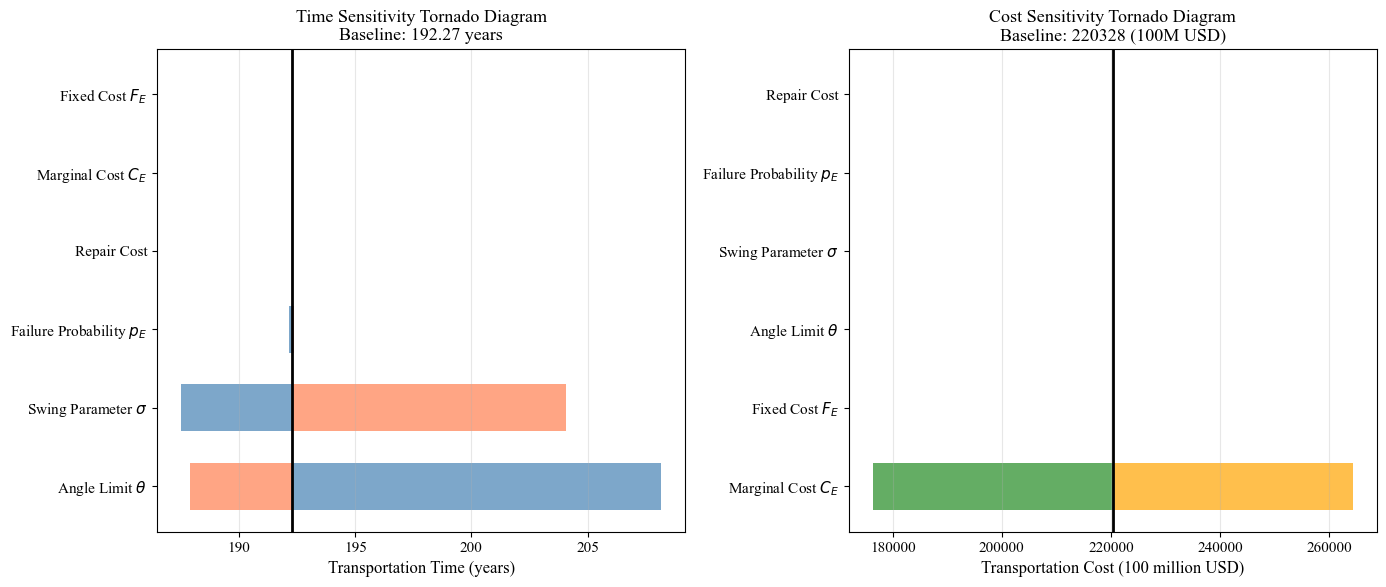

In [9]:
# ==================== Visualization 3: Tornado Diagram ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Parameter name mapping (English)
param_labels = {
    'p_E': 'Failure Probability $p_E$',
    'sigma_swing': 'Swing Parameter $\sigma$',
    'theta_limit': 'Angle Limit $\\theta$',
    'val_rep_E': 'Repair Cost',
    'C_E': 'Marginal Cost $C_E$',
    'F_E': 'Fixed Cost $F_E$'
}

# Time Tornado Diagram
ax1 = axes[0]
y_pos = np.arange(len(sens_T))
for i, s in enumerate(sens_T):
    ax1.barh(i, s['low'] - baseline_T, left=baseline_T, height=0.6, 
             color='steelblue', alpha=0.7)
    ax1.barh(i, s['high'] - baseline_T, left=baseline_T, height=0.6, 
             color='coral', alpha=0.7)
ax1.axvline(baseline_T, color='black', linestyle='-', linewidth=2)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([param_labels.get(s['param'], s['param']) for s in sens_T])
ax1.set_xlabel('Transportation Time (years)', fontsize=12)
ax1.set_title(f'Time Sensitivity Tornado Diagram\nBaseline: {baseline_T:.2f} years', fontsize=13)
ax1.grid(True, axis='x', alpha=0.3)

# Cost Tornado Diagram
ax2 = axes[1]
for i, s in enumerate(sens_C):
    ax2.barh(i, s['low'] - baseline_C, left=baseline_C, height=0.6, 
             color='forestgreen', alpha=0.7)
    ax2.barh(i, s['high'] - baseline_C, left=baseline_C, height=0.6, 
             color='orange', alpha=0.7)
ax2.axvline(baseline_C, color='black', linestyle='-', linewidth=2)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([param_labels.get(s['param'], s['param']) for s in sens_C])
ax2.set_xlabel('Transportation Cost (100 million USD)', fontsize=12)
ax2.set_title(f'Cost Sensitivity Tornado Diagram\nBaseline: {baseline_C:.0f} (100M USD)', fontsize=13)
ax2.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/sensitivity_tornado.png', dpi=300, bbox_inches='tight')
plt.show()

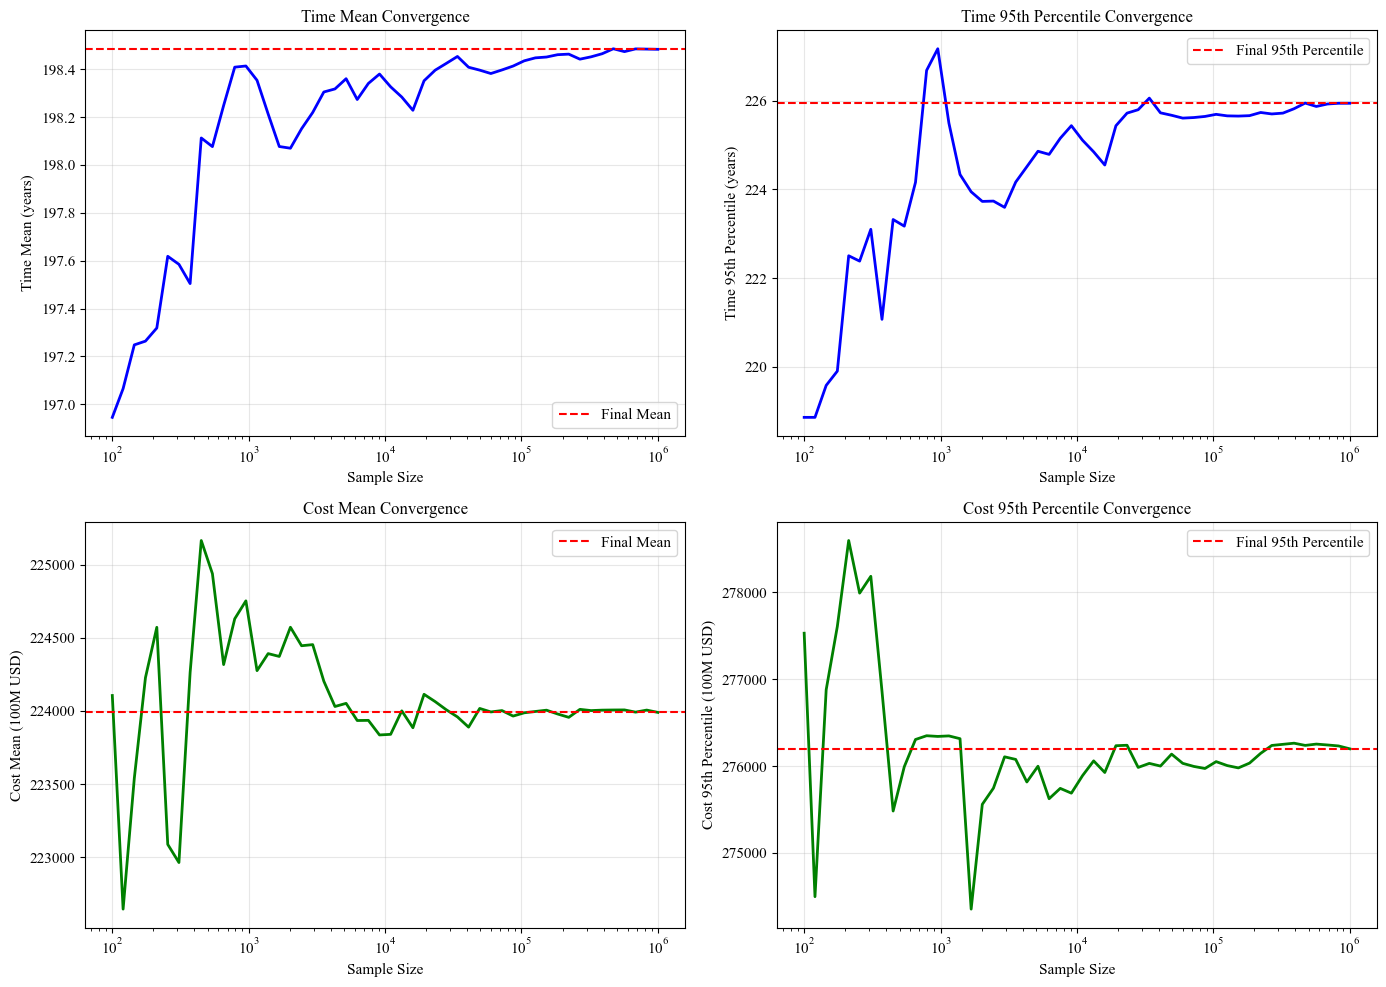


Convergence Test: Curves stabilize as sample size increases, indicating simulation convergence.


In [10]:
# ==================== Convergence Test ====================
def convergence_test(results, metric='T', n_points=50):
    """Test Monte Carlo simulation convergence"""
    data = results[metric]
    n_total = len(data)
    
    sample_sizes = np.logspace(2, np.log10(n_total), n_points).astype(int)
    means = []
    stds = []
    p95s = []
    
    for n in sample_sizes:
        subset = data[:n]
        means.append(np.mean(subset))
        stds.append(np.std(subset))
        p95s.append(np.percentile(subset, 95))
    
    return sample_sizes, means, stds, p95s

# Time convergence
sizes_T, means_T, stds_T, p95s_T = convergence_test(mc_results, 'T')
# Cost convergence
sizes_C, means_C, stds_C, p95s_C = convergence_test(mc_results, 'C')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time Mean Convergence
ax1 = axes[0, 0]
ax1.semilogx(sizes_T, means_T, 'b-', linewidth=2)
ax1.axhline(np.mean(mc_results['T']), color='red', linestyle='--', label='Final Mean')
ax1.set_xlabel('Sample Size', fontsize=11)
ax1.set_ylabel('Time Mean (years)', fontsize=11)
ax1.set_title('Time Mean Convergence', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time 95th Percentile Convergence
ax2 = axes[0, 1]
ax2.semilogx(sizes_T, p95s_T, 'b-', linewidth=2)
ax2.axhline(T_95, color='red', linestyle='--', label='Final 95th Percentile')
ax2.set_xlabel('Sample Size', fontsize=11)
ax2.set_ylabel('Time 95th Percentile (years)', fontsize=11)
ax2.set_title('Time 95th Percentile Convergence', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cost Mean Convergence
ax3 = axes[1, 0]
ax3.semilogx(sizes_C, means_C, 'g-', linewidth=2)
ax3.axhline(np.mean(mc_results['C']), color='red', linestyle='--', label='Final Mean')
ax3.set_xlabel('Sample Size', fontsize=11)
ax3.set_ylabel('Cost Mean (100M USD)', fontsize=11)
ax3.set_title('Cost Mean Convergence', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Cost 95th Percentile Convergence
ax4 = axes[1, 1]
ax4.semilogx(sizes_C, p95s_C, 'g-', linewidth=2)
ax4.axhline(C_95, color='red', linestyle='--', label='Final 95th Percentile')
ax4.set_xlabel('Sample Size', fontsize=11)
ax4.set_ylabel('Cost 95th Percentile (100M USD)', fontsize=11)
ax4.set_title('Cost 95th Percentile Convergence', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/sensitivity_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConvergence Test: Curves stabilize as sample size increases, indicating simulation convergence.")

In [11]:
# ==================== 最终结论汇总 ====================
print("\n" + "="*70)
print("🎯 Plan A (纯电梯) 灵敏度分析 - 最终结论")
print("="*70)

print(f"""
【蒙特卡洛模拟配置】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  模拟次数: {N_SIM:,}
  随机种子: 42 (可复现)
  
  参数分布:
    • 故障概率 p_E: Beta(3, 97), 均值≈0.03
    • 摆动参数 σ: Normal(0.25, 0.05), 截断[0.1, 0.5]
    • 角度限制 θ: Uniform(3, 7)
    • 维修费用: Lognormal(ln(50亿), 0.3)
    • 边际成本 C_E: Triangular(3M, 3.5M, 4.5M)

【核心结论: 置信分位数】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  📊 运输时间:
     • 均值: {np.mean(mc_results['T']):.2f} 年
     • 90% 概率 ≤ {T_90:.2f} 年
     • 95% 概率 ≤ {T_95:.2f} 年
     • 99% 概率 ≤ {np.percentile(mc_results['T'], 99):.2f} 年
  
  💰 运输成本:
     • 均值: {np.mean(mc_results['C']):.2f} 亿USD
     • 90% 概率 ≤ {C_90:.2f} 亿USD
     • 95% 概率 ≤ {C_95:.2f} 亿USD
     • 99% 概率 ≤ {np.percentile(mc_results['C'], 99):.2f} 亿USD

【灵敏度排序】(影响最大的参数)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  时间最敏感: {sens_T[0]['param']} (±20%扰动影响 {sens_T[0]['range']:.4f}年)
  成本最敏感: {sens_C[0]['param']} (±20%扰动影响 {sens_C[0]['range']:.2f}亿USD)

【风险提示】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • 相比基准期望值，95%置信上限增加:
    - 时间: +{(T_95/E_T_base - 1)*100:.1f}% ({T_95 - E_T_base:.2f}年)
    - 成本: +{(C_95/E_C_base - 1)*100:.1f}% ({C_95 - E_C_base:.2f}亿USD)
  
  • 建议预留风险储备:
    - 时间储备: ≥{T_95 - E_T_base:.2f} 年
    - 成本储备: ≥{C_95 - E_C_base:.2f} 亿USD
""")

print("\n图像已保存到 results/ 目录:")
print("  1. sensitivity_distributions.png - 分布直方图")
print("  2. sensitivity_cdf.png - 累积分布函数")
print("  3. sensitivity_tornado.png - 龙卷风图")
print("  4. sensitivity_convergence.png - 收敛性检验")


🎯 Plan A (纯电梯) 灵敏度分析 - 最终结论

【蒙特卡洛模拟配置】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  模拟次数: 1,000,000
  随机种子: 42 (可复现)
  
  参数分布:
    • 故障概率 p_E: Beta(3, 97), 均值≈0.03
    • 摆动参数 σ: Normal(0.25, 0.05), 截断[0.1, 0.5]
    • 角度限制 θ: Uniform(3, 7)
    • 维修费用: Lognormal(ln(50亿), 0.3)
    • 边际成本 C_E: Triangular(3M, 3.5M, 4.5M)

【核心结论: 置信分位数】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  📊 运输时间:
     • 均值: 198.48 年
     • 90% 概率 ≤ 213.01 年
     • 95% 概率 ≤ 225.94 年
     • 99% 概率 ≤ 257.30 年
  
  💰 运输成本:
     • 均值: 223990.42 亿USD
     • 90% 概率 ≤ 266022.67 亿USD
     • 95% 概率 ≤ 276198.90 亿USD
     • 99% 概率 ≤ 289730.80 亿USD

【灵敏度排序】(影响最大的参数)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  时间最敏感: theta_limit (±20%扰动影响 20.2641年)
  成本最敏感: C_E (±20%扰动影响 88000.00亿USD)

【风险提示】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • 相比基准期望值，95%置信上限增加:
    - 时间: +17.5% (33.67年)
    - 成本: +25.4% (55871.01亿USD)
  
  • 建议预留风险储备:
    - 时间储备: ≥33.67 年
    - 成本储备

In [12]:

# ==================== Payload Sweep: P_avg 125→200 ====================
# 目的：枚举P_avg，计算每个载荷下的最优α、对应时间T与成本C，并绘制三张曲线图。

P_range = np.arange(125, 201, 1)  # 125~200 tons/launch
alphas = np.linspace(0, 1, 10001)  # keep 4-decimal precision

def plan_C_stats_with_payload(alpha, P_payload):
    """基于给定P_payload计算混合方案期望与标准差"""
    # === 电梯部分 ===
    if alpha > 0:
        E_T_E = alpha * M / (E_E * (1 - p_E))
        Var_T_E = alpha * M * p_E / (E_E * (1 - p_E)**2)
    else:
        E_T_E = 0
        Var_T_E = 0

    # === 火箭部分（使用P_payload） ===
    if alpha < 1:
        E_T_R = (1 - alpha) * M / P_payload / (N * q_R)
        Var_T_R = (1 - q_R) * ((1 - alpha) * M)**2 / (N**3 * q_R**3 * P_payload**2)
    else:
        E_T_R = 0
        Var_T_R = 0

    # === 总时间 ===
    E_T_C = max(E_T_E, E_T_R)
    Var_T_C = Var_T_E if E_T_E >= E_T_R else Var_T_R
    Std_T_C = sqrt(Var_T_C) if Var_T_C > 0 else 0

    # === 电梯成本 ===
    if alpha > 0:
        E_C_E = (alpha * M * C_E +
                 alpha * M * F_E / E_E +
                 alpha * M * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
        Var_C_E = (alpha**2 * M * p_E * val_rep_E**2 / (E_E * (1 - p_E)**2)) / 10**16
    else:
        E_C_E = 0
        Var_C_E = 0

    # === 火箭成本（使用P_payload） ===
    if alpha < 1:
        M_R = (1 - alpha) * M
        E_C_R = (M_R * C_R / q_R +
                 val_R * M_R * (1 - q_R) / (P_payload * q_R) +
                 M_R / (N * q_R * P_payload)) / 10**8
        Var_C_R = ((1 - alpha)**2 *
                   (C_R**2 * P_payload * M * (1 - q_R) / q_R**2 +
                    val_R**2 * M * (1 - q_R) / (P_payload * q_R**2) +
                    (1 - q_R) * M**2 / (N**3 * q_R**3 * P_payload**2))) / 10**16
    else:
        E_C_R = 0
        Var_C_R = 0

    E_C_C = E_C_E + E_C_R
    Var_C_C = Var_C_E + Var_C_R
    Std_C_C = sqrt(Var_C_C) if Var_C_C > 0 else 0

    return E_T_C, Std_T_C, E_C_C, Std_C_C

def normalize(arr):
    arr_min, arr_max = arr.min(), arr.max()
    if arr_max - arr_min < 1e-10:
        return np.zeros_like(arr)
    return (arr - arr_min) / (arr_max - arr_min)

# 记录结果
alpha_opt_list = []
T_opt_list = []
C_opt_list = []

# 使用方案2权重（与主文一致）
w1, w2, w3, w4 = 0.35, 0.25, 0.25, 0.15

for P_payload in P_range:
    # 遍历α
    E_T_arr = []
    E_C_arr = []
    Std_T_arr = []
    Std_C_arr = []
    for alpha in alphas:
        E_T, Std_T, E_C, Std_C = plan_C_stats_with_payload(alpha, P_payload)
        E_T_arr.append(E_T)
        E_C_arr.append(E_C)
        Std_T_arr.append(Std_T)
        Std_C_arr.append(Std_C)

    E_T_arr = np.array(E_T_arr)
    E_C_arr = np.array(E_C_arr)
    Std_T_arr = np.array(Std_T_arr)
    Std_C_arr = np.array(Std_C_arr)

    # 归一化并计算综合得分
    E_T_norm = normalize(E_T_arr)
    E_C_norm = normalize(E_C_arr)
    Std_T_norm = normalize(Std_T_arr)
    Std_C_norm = normalize(Std_C_arr)
    scores = w1 * E_C_norm + w2 * E_T_norm + w3 * Std_C_norm + w4 * Std_T_norm

    best_idx = np.argmin(scores)
    alpha_opt = alphas[best_idx]
    alpha_opt_list.append(alpha_opt)
    T_opt_list.append(E_T_arr[best_idx])
    C_opt_list.append(E_C_arr[best_idx])

alpha_opt_list = np.array(alpha_opt_list)
T_opt_list = np.array(T_opt_list)
C_opt_list = np.array(C_opt_list)

print("Payload sweep completed!")
print(f"P_avg range: {P_range.min()} to {P_range.max()} tons")
print(f"Alpha* range: {alpha_opt_list.min():.4f} to {alpha_opt_list.max():.4f}")
print(f"Time range: {T_opt_list.min():.2f} to {T_opt_list.max():.2f} years")
print(f"Cost range: {C_opt_list.min():.2f} to {C_opt_list.max():.2f} (100M USD)")

# ==================== Plot 1: alpha* vs P_avg ====================
plt.figure(figsize=(10, 6))
plt.plot(P_range, alpha_opt_list, 'b-', linewidth=2)
plt.xlabel('Rocket Payload $P_{avg}$ (tons/launch)', fontsize=12)
plt.ylabel('Optimal $\\alpha^*$', fontsize=12)
plt.title('Optimal $\\alpha$ vs Rocket Payload', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/planC_std_payload_alpha.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== Plot 2: Time vs P_avg ====================
plt.figure(figsize=(10, 6))
plt.plot(P_range, T_opt_list, 'g-', linewidth=2)
plt.xlabel('Rocket Payload $P_{avg}$ (tons/launch)', fontsize=12)
plt.ylabel('Optimal Expected Time (years)', fontsize=12)
plt.title('Optimal Time vs Rocket Payload', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/planC_std_payload_time.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== Plot 3: Cost vs P_avg ====================
plt.figure(figsize=(10, 6))
plt.plot(P_range, C_opt_list, 'r-', linewidth=2)
plt.xlabel('Rocket Payload $P_{avg}$ (tons/launch)', fontsize=12)
plt.ylabel('Optimal Expected Cost (100M USD)', fontsize=12)
plt.title('Optimal Cost vs Rocket Payload', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/planC_std_payload_cost.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figures saved:")
print("  1. planC_std_payload_alpha.png")
print("  2. planC_std_payload_time.png")
print("  3. planC_std_payload_cost.png")

NameError: name 'M' is not defined